# Geographic Profiling with Open Street Map

In [1]:
import pandas
import numpy as np
import geopandas as gpd
import osmnx as ox
import networkx as nx
from haversine import haversine
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch
import folium
from folium.plugins import HeatMap
#%matplotlib inline
import matplotlib.pyplot as plt
import pdb
import time

##### Choosing city and transportation mode

In [2]:
transport_mode = 'walk'

##### Specify the path and read victims list

In [19]:
path2csv = 'victims.csv'
vics = pandas.read_csv(path2csv)

##### Filter victims

In [20]:
selection = (vics['Confirmed Axeman'] == 'Yes') | (vics['Confirmed Axeman'] == 'Maybe')
# selection = vics['Latitude'] > 0 
vicselect = vics.loc[selection,['Latitude','Longitude']]

##### The list of selected victims is

In [21]:
vics[selection]

,Victim,Time,Victims #,Attacked / Murdered / Break-in,Location,Latitude,Longitude,Confirmed Axeman
0,August Crutti,13/08/1910,1,Attacked,Royal St. and Lesseps St.,29.960853,-90.033930,Yes
1,Joseph Rissetto,20/09/1910,2,Attacked,Tonti St. and A.P. Tureaud Avenue,29.980195,-90.067196,Yes
2,Joseph Davi,26/06/1911,2,Murdered,Arts and Galvez St.,29.979005,-90.053034,Yes
7,Joseph Maggio,24/05/1918,2,Murdered,Upperline St. and Magnolia St.,29.937011,-90.107449,Yes
8,Louis Besumer,26/06/1918,2,Murdered,Dorgenois St. and Laharpe St.,29.977528,-90.076837,Maybe
9,Mary Schneider,05/08/1918,1,Attacked,1320 Elmira St.,29.941846,-90.047888,Yes
10,Joseph Romano,10/08/1918,3,Murdered,2336 Gravier St.,29.958806,-90.087881,Yes
14,Charles Cortimiglia,10/03/1919,3,Murdered,Second St. Gretna,29.916872,-90.062618,Yes
17,Mike Pepitone,27/10/1919,1,Murdered,S Scott St. and Ulloa St.,29.968005,-90.105312,Yes


In [6]:
lat = vicselect['Latitude']
lon = vicselect['Longitude']

## Bounding box
The formula to get the boundaries of the bounding box are given in *Geographic Profiling* (2000) by Dr. Kim Rossmo:

$y_\text{high} = y_\text{max} + \left(N-1\right) \frac{y_\text{max}-y_\text{min}}{2}$

$y_\text{low} = y_\text{min} - \left(N-1\right) \frac{y_\text{max}-y_\text{min}}{2}$

$x_\text{high} = x_\text{max} + \left(N-1\right) \frac{x_\text{max}-x_\text{min}}{2}$

$x_\text{low} = x_\text{min} - \left(N-1\right) \frac{x_\text{max}-x_\text{min}}{2}$

Where:

$y_\text{high}$ is the $y$ value of the northernmost boundary 

$y_\text{low}$ is the $y$ value of the southermost boundary

$y_\text{max}$ is the maximum $y$ value for any crime site

$y_\text{min}$ is the minimum $y$ value for any crime site

$x_\text{high}$ is the $y$ value of the easternmost boundary

$x_\text{low}$ is the $y$ value of the westernmost boundary

$x_\text{max}$ is the maximum $x$ value for any crime site

$x_\text{min}$ is the minimum $x$ value for any crime site

and $N$ is the total number of crime sites

In [7]:
def get_bounding_box(vicselect,mode='strict',e=0.01):
    # vicselect = pandas dataframe of victims
    # mode = 'default', 'strict'
    # e = little padding distance in angles
    
    lat = vicselect['Latitude']
    lon = vicselect['Longitude']
    
    if mode.lower() in ['default']:
        C = len(lat)
    
        ymax, ymin = max(lat), min(lat)
        xmax, xmin = max(lon), min(lon)
    
        yhigh = ymax + (C-1)*(ymax-ymin)/2.
        ylow  = ymin - (C-1)*(ymax-ymin)/2.
        xhigh = xmax + (C-1)*(xmax-xmin)/2.
        xlow  = xmin - (C-1)*(xmax-xmin)/2.
        
    elif mode.lower() in ['strict']:
        yhigh = lat.max()+e
        ylow  = lat.min()-e
        xhigh = lon.max()+e
        xlow  = lon.min()-e
    else:
        raise Exception('mode should be ''default'' or ''strict''')
    
    
    
    return yhigh, ylow, xhigh, xlow

#### Get the graph of the location

In [8]:
bbox_mode = 'strict' #strict
buffer = 0.05 

yhigh, ylow, xhigh, xlow = get_bounding_box(vicselect,mode=bbox_mode,e=buffer)

G = ox.core.graph_from_bbox(yhigh, ylow, xhigh, xlow, network_type='all_private',
                            simplify=True, retain_all=False, truncate_by_edge=False,
                            name='unnamed', timeout=180, memory=None, max_query_area_size=2500000000, 
                            clean_periphery=True, infrastructure='way["highway"]', custom_filter=None)

gdf_nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)

try:
    gdf_nodes.drop(['highway','ref'], inplace=True, axis=1)
except:
    pass
    
print(f"{len(gdf_nodes)} points acquired")
gdf_nodes.head()

24525 points acquired


,y,x,osmid,geometry
115998720,30.008514,-90.106339,115998720,POINT (-90.1063393 30.0085142)
116064256,29.938108,-90.067983,116064256,POINT (-90.0679828 29.9381084)
116064258,29.939050,-90.069856,116064258,POINT (-90.0698561 29.9390498)
115998723,30.010314,-90.106119,115998723,POINT (-90.10611919999999 30.0103142)
116064260,29.939622,-90.072381,116064260,POINT (-90.07238099999999 29.939622)


#### Showing the victim's locations

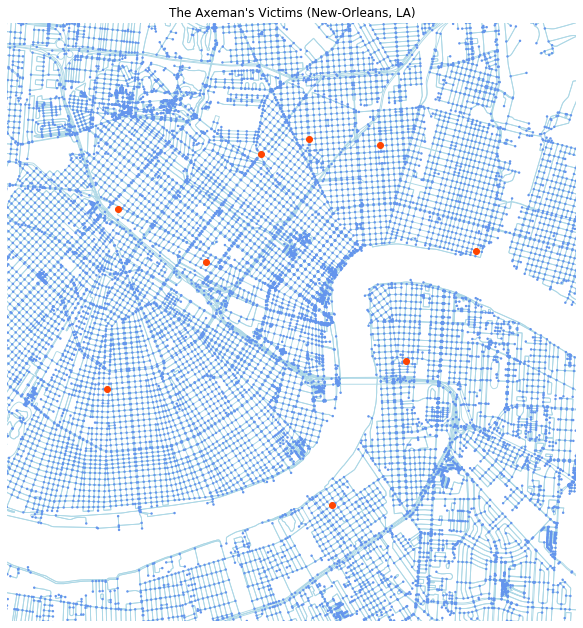

In [22]:
e = 0.02 ; # little bit of extra margin around the dots for context
fig, ax = ox.plot_graph(G,bbox=(vicselect['Latitude'].max()+e,vicselect['Latitude'].min()-e,
                                vicselect['Longitude'].max()+e,vicselect['Longitude'].min()-e),
                        margin=0, fig_height=11, 
                        node_size=6, node_zorder=3, node_color = 'cornflowerblue',
                        edge_color = 'lightblue', edge_linewidth = 0.9,
                        show=False, close=False, axis_off=True)

ax.scatter(vicselect['Longitude'], vicselect['Latitude'], c='orangered', zorder=4)
plt.title('The Axeman\'s Victims (New-Orleans, LA)')
plt.show()

#fig.savefig("victims.png",dpi=200,pad_inches=0,bbox_inches='tight')

## Using Rossmo's formula

##### Define buffer/distance decay function:

$$f(d) = \begin{cases}
            \frac{k}{d^f} & \text{ if } d \gt B \\
            \frac{k B^{g-f}}{(2B - d)^g} & \text{ if } d \le B
        \end{cases} $$
        
Where $d$ is the distance from the anchor point, $k$ is constant, $B$ is the buffer zone radius and $g$ and $h$ are values describing the criminal's attributes e.g. the mode of travel they use.

In practice Rossmo in his thesis chooses $B$ to be one half the mean of the nearest neighbor distance between crimes (using a Manhattan metric). Also $f = 1.2$ was chosen from a gravity model formulation developed to describe interprovincial migration patterns of criminal fugtives (Rossmo, 1987, p. 136). The same exponent was used for distances both within and outside the buffer sone radius ($g = f$).

$k$ is only used to prevent "program variable overflow" (variable values must remain within the precision range of the specified integer and floating-point numeric variable types used). Basically just try different values and see what happens...

The distance-decay function could be improved by describing the buffer zone as an annulus instead of a radius. This could be achieved by using a third or fourth-order polynomial function.

In [10]:
def buffer_distance_decay(d,k,B,g=1.2,f=1.2):
    if d > B:
        return k/(d**f)
    else:
        return k*(B**(g-f))/((2*B-d)**g)

#### Score of a cell

For a cell (or node) $\mathbf{p}$, the score $S$ attributed is given by:

$$ S(\mathbf{p}) = \sum_{i=1}^{N} f\left(d\left(\mathbf{p},\mathbf{c_i}\right)\right) $$

Where $N$ is the total number of crimes; $d\left(\mathbf{p},\mathbf{c_i}\right)$ is the distance from cell $\mathbf{p}$ to crime $\mathbf{c_i}$. Rossmo uses a Manhattanian distance for $d$. Here, we use the actual walking distance depending on the city network.

#### Defining distances

In [11]:
def get_path_length(graph, orig_node, target_node):
    length = nx.shortest_path_length(G=graph, source=orig_node, target=target_node, weight='length')
    return length

def get_manhattan_haversine(point1,point2):
    # point = (lat,lon)
    # haversine((lat[0],lon[0]),(lat[1],lon[1]),unit="m")
    # returns the manhattan distance using haversine formula
    return abs(haversine((0,point1[1]),(0,point2[1]),unit="m")) + abs(haversine((point1[0],0),(point2[0],0),unit="m"))

#### Estimating B parameters

In [12]:
def estimate_B(lat,lon):
    # In practice Rossmo in his thesis chooses B to be 
    # one half the mean of the nearest neighbor distance between crimes (using a Manhattan metric)
    def nearest_neighbor_distance(thelat,thelon,lat,lon):
        distances = []
        for clat, clon in zip(lat,lon):
            #pdb.set_trace()
            distances.append(get_manhattan_haversine((thelat,thelon),(clat,clon)))
        
        idx = np.argpartition(distances, 2) # index of the two smallest values
        
        nnd = distances[idx[1]]        
        return nnd
    
    nnds = []
    for clat, clon in zip(lat,lon):
        nnds.append(nearest_neighbor_distance(clat,clon,lat,lon))

    B = (1/2.)*np.mean(nnds)
    
    return B
        
B = estimate_B(lat,lon)
print(f"B is equal to {B:1.0f} m")

B is equal to 1433 m


#### Computing Score

In [23]:
def compute_score(G,vics,gdf_nodes,k,B,g=1.2,f=1.2,method='manhattan'):
    # G = graph (networkx)
    # vics = pandas DataFrame containing the list of victims with Longitude/Latitude as attributes
    # gdf = geodataframe of nodes containing the information
    # method = "truelength, manhattan"
    # k, B, g, f are parameters for the decay function
    
    N = len(vics)

    # get nearest node for every victim
    vics['NearestNode'] = vics.apply(lambda x: ox.get_nearest_node(G, (x['Latitude'], x['Longitude'])), axis=1)
        
    # Loop through all the nodes in gdf_nodes and compute
    def process_one_node(G,osmid,lat,lon,vics,method='manhattan'):        
        score = 0
        for i in range(N):
            if method.lower() in ['truelength']:
                try:
                    distance = get_path_length(G,osmid,vics['NearestNode'].iloc[i])
                except:
                    distance = float('inf')
            
            elif method.lower() in ['manhattan','haversine']:
                distance = get_manhattan_haversine((lat,lon),(vics['Latitude'].iloc[i],vics['Longitude'].iloc[i]))
            else:
                raise Exception('method should be truelength or manhattan')
            score += buffer_distance_decay(distance,k,B,g,f)
        return score
    
    gdf_nodes['Score'] = gdf_nodes.apply(lambda row: process_one_node(G, row['osmid'], row['y'], row['x'],vics,method), axis=1)
        
    return gdf_nodes


t0 = time.time() ;
lengthmethod = 'manhattan'
gdf_nodes = compute_score(G,vicselect,gdf_nodes,k=1e6,B=B,g=1.2,f=1.2,method=lengthmethod)
t1 = time.time() ;

# gdf_nodes.to_file("gdf_nodes2.json", driver="GeoJSON")

print(f"Computation time took {(t1-t0)/60:.5f} minutes = {t1-t0:.0f} seconds using the {lengthmethod} distance")
gdf_nodes.head()


Computation time took 0.21599 minutes = 13 seconds using the manhattan distance


,y,x,osmid,Score,geometry
0,30.008514,-90.106339,115998720,179.590918,POINT (-90.1063393 30.0085142)
1,29.938108,-90.067983,116064256,378.779893,POINT (-90.0679828 29.9381084)
2,29.939050,-90.069856,116064258,373.987837,POINT (-90.0698561 29.9390498)
3,30.010314,-90.106119,115998723,174.322949,POINT (-90.10611919999999 30.0103142)
4,29.939622,-90.072381,116064260,368.694208,POINT (-90.07238099999999 29.939622)


In [15]:
gdf_nodes = gpd.read_file('gdf_nodes2.json')

### Plotting the score as a heat map
We use the folium library to do that

In [24]:
def generateBaseMap(vicselect, default_zoom_start=12,tilelayer = 'openstreetmap'):
    lat0 = vicselect['Latitude'].median() ;
    lon0 = vicselect['Longitude'].median()
    base_map = folium.Map(location=[lat0,lon0], control_scale=True, zoom_start=default_zoom_start,tiles=tilelayer)
    return base_map

m = generateBaseMap(vicselect,14,'openstreetmap')
m

data = list(zip(gdf_nodes['y'].values, gdf_nodes['x'].values,gdf_nodes['Score'].values))
hm = HeatMap(data, min_opacity=0, max_val = np.percentile(gdf_nodes['Score'],1),
                     radius=5, blur=7,
                     max_zoom=1)
m.add_child(hm)

#### Method for Rossmo's formula

In [27]:
# def make_rossmo_polys(G, victim_lon, victim_lat, edge_buff=25, node_buff=50, infill=False):
    
#     rossmo_polys = []

#     node_points = [Point((data['x'], data['y'])) for node, data in G.nodes(data=True)]
        
#     nodes_gdf = gpd.GeoDataFrame({'id': G.nodes()}, geometry=node_points)
#     nodes_gdf = nodes_gdf.set_index('id')

#     edge_lines = []
        
#     for n_fr, n_to in G.edges():
            
#         f = nodes_gdf.loc[n_fr].geometry
#         t = nodes_gdf.loc[n_to].geometry
#         edge_lines.append(LineString([f,t]))

#         n = nodes_gdf.buffer(node_buff).geometry
#         e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
#         all_gs = list(n) + list(e)
#         new_iso = gpd.GeoSeries(all_gs).unary_union
#         # If desired, try and "fill in" surrounded
#         # areas so that shapes will appear solid and blocks
#         # won't have white space inside of them
#         if infill:
#             new_iso = Polygon(new_iso.exterior)
#             rossmo_polys.append(new_iso)

# return rossmo_polys

# # First, run our new method
# rossmo_polys = make_rossmo_polys(G, lon, lat, 25, 50, True)

# # And use the results in the plot, just as we were performing these steps originally
# fig, ax = ox.plot_graph(G,bbox=(lat.max()+e,lat.min()-e,lon.max()+e,lon.min()-e),
#                         margin=0, fig_height=11, 
#                         node_size=6, node_zorder=3, node_color = 'cornflowerblue',
#                         edge_color = 'lightblue', edge_linewidth = 0.9,
#                         show=False, close=False, axis_off=True)

# ax.scatter(lon, lat, c='orangered', zorder=4)
# plt.title('The Axeman\'s Victims (New-Orleans, LA)')
# plt.show()

# for polygon, fc in zip(rossmo_polys, iso_colors):
# patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
# ax.add_patch(patch)
# plt.show()

# count = 0
# ntarget = 123338769
# for n in G.nodes():
#     count += 1
#     length = get_path_length(G,n,ntarget)
# #     print(G.node[n]['lat'])
#     print(list(G.nodes(data=True)))
#     if count == 5:
#         break



## Using a Dirichlet process mixture model